In [17]:
#HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()
from modules import la

# Rural/Urban scoring for councils

There are measures of Rural/Urban in England/Wales and Scotland which are slightly incomparable. 

We have previously combined these for the LSOA level into three bands. These are hard to exactly scale up to local authority level. ONS did this for for E/W but the Scottish notes give up and just say you should express it as the proportion of different bands in different local authorities. 

This notebook is an experiment in producing that from our previous LSOA data, and then seeing if this data easily clusters in a way that can be nicely labelled.

The difference between this and the measure in the league filter notebook is it expands up to higher tiers, given they are in a comparable set.

In [18]:
# bring in the uk-wide composite ruc info#
ruc = pd.read_csv(Path("data", "source", "composite_ruc.csv"))
ruc = ruc[["lsoa", "ukruc-3", "pop"]].set_index("lsoa")

In [19]:
# get this into the form of a sheet where the percentage of each lower-tier la is urban, rural, and highly rural is a row 

df = pd.read_csv(Path("data", "source", "lsoa_la_2021.csv")).set_index("lsoa")
df = ruc.join(df, how="outer")
df["ukruc-3"] = df["ukruc-3"].map({0:"Urban", 1: "Rural", 2: "Highly rural"})
pt = df.pivot_table("pop", index="local-authority-code", columns=["ukruc-3"], aggfunc="sum").fillna(0)

# add higher levels
hpt = pt.la.to_multiple_higher(aggfunc="sum").set_index("local-authority-code")
pt = pd.concat([pt, hpt])

pt = pt.common.row_percentages()

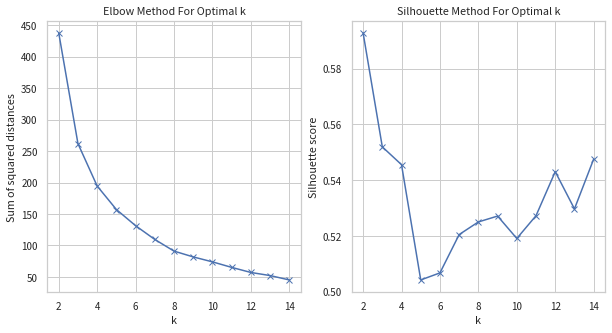

In [20]:
# now look to see if obvious clusters

c = pt.space.cluster()
c.find_k()

Not *great* clustering behaviour here (to be expected, more of a spectrum). Instead lets work backwards, we want a fairly basic breakdown, so lets pick 4.

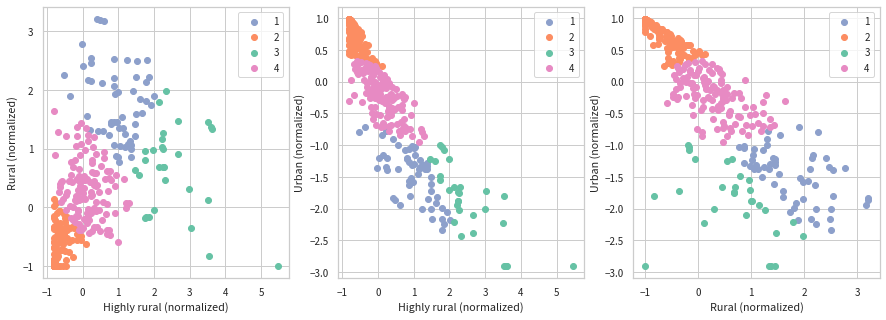

In [21]:
c.set_k(4).plot()

These seem ok grouping (although obviously at the margins the limit is not hard). 

In [22]:
c = c.set_k(4).add_labels({2:"Urban", 3:"Sparse rural", 4: "Sub urban", 1: "Rural"})
c.stats()

,count,%,random members
labels,,,
1: Rural,56,13.7,"[SSO, BAB, RIH, CLK, CAM]"
2: Urban,199,48.7,"[SHN, HMF, SGC, PLY, BRD]"
3: Sparse rural,29,7.1,"[HEF, MAV, ABD, CGN, AGB]"
4: Sub urban,125,30.6,"[WAR, HIG, GRY, DOV, STO]"


In [23]:
pt["cluster"] = c.label_array(include_short=False)

ldf = la.get_la_with_leagues().set_index("local-authority-code")
ldf = ldf.join(pt, how="outer")

ldf.reset_index().pivot_table("local-authority-code", index="league-group", columns="cluster", aggfunc="count").fillna(0)

cluster,Rural,Sparse rural,Sub urban,Urban
league-group,,,,
Combined/strategic authorities,0.0,0.0,3.0,8.0
County councils,5.0,0.0,16.0,3.0
District councils,40.0,10.0,67.0,64.0
Northern Ireland,0.0,5.0,5.0,1.0
Single tier,11.0,14.0,34.0,123.0


Final question is how does this match up against the official measures?

## Comparing to E/W RUC

The Scotland one isn't avaliable as a one off value. 

In [24]:
ewruc = pd.read_csv(Path("data", "source", "RUC_LAD_2011_EN_LU.csv"))

ewruc = ewruc.la.create_code_column(from_type="gss", source_col="LAD18CD", set_index=True)

combo = ewruc[["Broad RUC11", "RUC11"]].join(pt[["cluster"]])

pd.crosstab(index=combo["Broad RUC11"], columns=combo["cluster"]).common.row_percentages().style.format(percentage_1dp)

cluster,Rural,Sparse rural,Sub urban,Urban
Broad RUC11,,,,
Predominantly Rural,52.5%,15.0%,32.5%,0.0%
Predominantly Urban,0.0%,0.0%,5.7%,94.3%
Urban with Significant Rural,4.3%,0.0%,85.1%,10.6%


This seems pretty good. Going to adapt the category names slightly. 

In [25]:
c = c.set_k(4).add_labels({2:"Urban", 3:"Sparse and rural", 4: "Urban with rural areas", 1: "Rural"})
c.stats()


,count,%,random members
labels,,,
1: Rural,56,13.7,"[CRA, COP, WLI, CAM, SHR]"
2: Urban,199,48.7,"[MDW, NOW, NLK, RDG, HAA]"
3: Sparse and rural,29,7.1,"[EDN, ORK, ABC, POW, CCG]"
4: Urban with rural areas,125,30.6,"[LAC, NAY, DOV, DST, BAN]"


In [26]:
pt["label"] = c.label_array(include_short=False)
final = pt.reset_index()[["local-authority-code",  "label"]]
final.to_csv(Path("data", "outputs", "ruc", "la_labels.csv"), index=False)

In [27]:
df = pd.Series(final["label"].unique()).to_frame()
df.columns = ["label"]

desc = {"Urban":"Local authority predominately made up of urban neighbourhoods",
"Rural":"Local authority predominately made up of rural neighbourhoods",
"Sparse and rural":"Local authority predominately made up of large and low-density rural neighbourhoods",
"Urban with rural areas":"Local authority mostly made up of urban neighbourhoods, but with a significant number of rural neighbourhoods",
}

df["desc"] = df["label"].map(desc)
df.to_csv(Path("data", "outputs", "ruc", "label_desc.csv"), index=False)
df

,label,desc
0,Sparse and rural,Local authority predominately made up of large...
1,Urban,Local authority predominately made up of urban...
2,Rural,Local authority predominately made up of rural...
3,Urban with rural areas,Local authority mostly made up of urban neighb...


# Export distance

In [28]:
df = pd.read_csv(Path("data", "source", "lsoa_la_2021.csv")).set_index("lsoa")
df = ruc.join(df, how="outer")
df["ukruc-3"] = df["ukruc-3"].map({0: "Urban", 1: "Rural", 2: "Highly rural"})
pt = df.pivot_table("pop", index="local-authority-code",
                    columns=["ukruc-3"], aggfunc="sum").fillna(0)

# add higher levels
hpt = pt.la.to_multiple_higher(aggfunc="sum").set_index("local-authority-code")
pt = pd.concat([pt, hpt])

pt = pt.common.row_percentages().reset_index()
pt.columns.name = None

pt = pt.la.add_info(["area", "pop-2020"])
pt["density"] = pt["area"] / pt["pop-2020"]
pt

,local-authority-code,Highly rural,Rural,Urban,area,pop-2020,density
0,ABC,4.07e-01,1.03e-01,0.49,1338.0,2.17e+05,6.16e-03
1,ABD,4.92e-01,2.12e-01,0.30,6313.0,2.61e+05,2.42e-02
2,ABE,2.46e-03,6.00e-02,0.94,186.0,2.29e+05,8.12e-04
3,ADU,0.00e+00,0.00e+00,1.00,42.0,6.42e+04,6.54e-04
4,AGB,4.70e-01,3.52e-01,0.18,6907.0,8.54e+04,8.08e-02
...,...,...,...,...,...,...,...
404,NTCA,7.12e-02,1.29e-01,0.80,5215.0,8.40e+05,6.21e-03
405,TVCA,2.85e-02,7.12e-02,0.90,795.0,6.77e+05,1.17e-03
406,WECA,4.89e-02,3.31e-02,0.92,953.0,9.50e+05,1.00e-03
407,WMCA,1.17e-03,6.76e-03,0.99,902.0,2.94e+06,3.07e-04


In [29]:
df = (pt
      .space.self_distance("local-authority-code", ["Highly rural", "Rural", "Urban", "density"], normalize=True)
      .space.match_distance()
      .space.local_rankings()
      .sort_values("distance"))

df.to_csv(Path("data", "outputs", "ruc", "distance_map.csv"), index=False)
df.head()

,local-authority-code_A,local-authority-code_B,distance,match,position
157496,WLV,COV,1.28e-06,100.0,1.0
32647,COV,WLV,1.28e-06,100.0,1.0
99561,NOW,LND,2.99e-06,100.0,1.0
82416,LND,NOW,2.99e-06,100.0,1.0
137507,STV,GOS,1.15e-05,100.0,1.0
